In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import  RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_validate



In [39]:
# Verisetindeki aykırı değerler aralığını belirlemek için kullanılacak fonksiyon
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# Verisetindeki aykırı değerleri kontrol etmek için kullanılacak fonksiyon
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

# Verisetindeki aykırı değerleri değiştirmek için kullanılacak fonksiyon
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [40]:
# EDA
df=pd.read_csv("C:/Users/azizd/Desktop/Miull/Machine Learning/machine_learning-220803-231749/machine_learning/datasets/diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.900,0.171,63,0
764,2,122,70,27,0,36.800,0.340,27,0
765,5,121,72,23,112,26.200,0.245,30,0
766,1,126,60,0,0,30.100,0.349,47,1


In [41]:
#Target analizi
df.Outcome.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

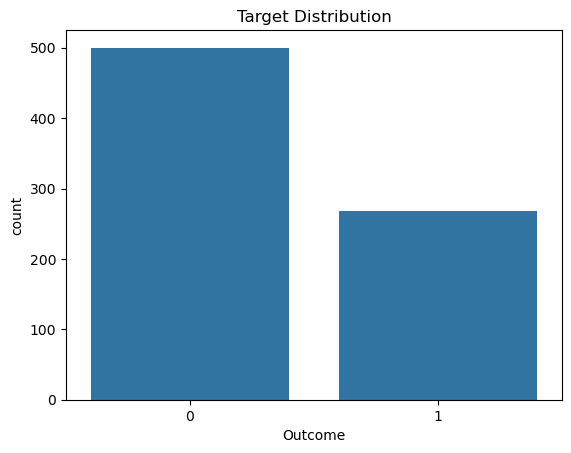

In [42]:
sns.countplot(x="Outcome", data=df)
plt.title("Target Distribution")
plt.show()


In [43]:
# Oranları
100* df.Outcome.value_counts() / len(df)
# 0: No Diabetes, 1: Diabetes

Outcome
0   65.104
1   34.896
Name: count, dtype: float64

In [44]:
# Feature analizi
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [45]:
def plot_numerical_col(dataframe,numerical_col):
	dataframe[numerical_col].hist(bins=20, color='blue', alpha=0.7)
	plt.xlabel(numerical_col)
	plt.show(block=True)

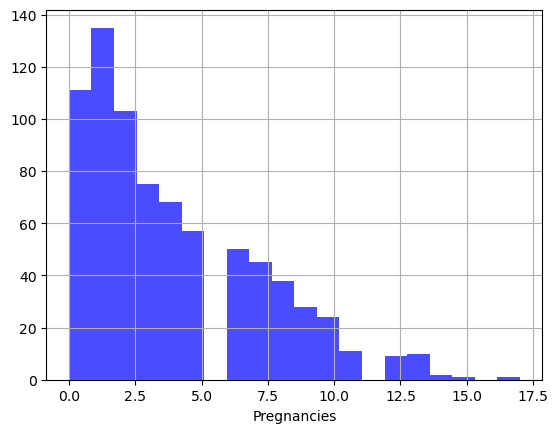

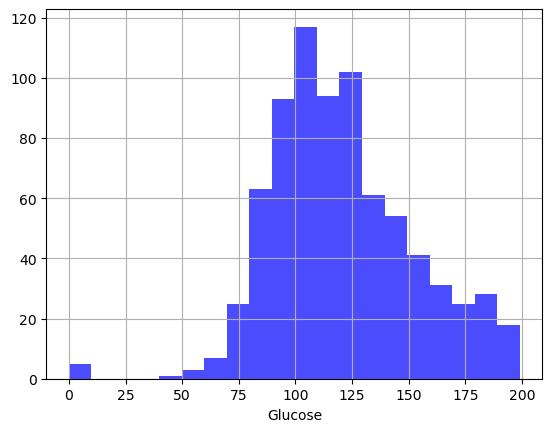

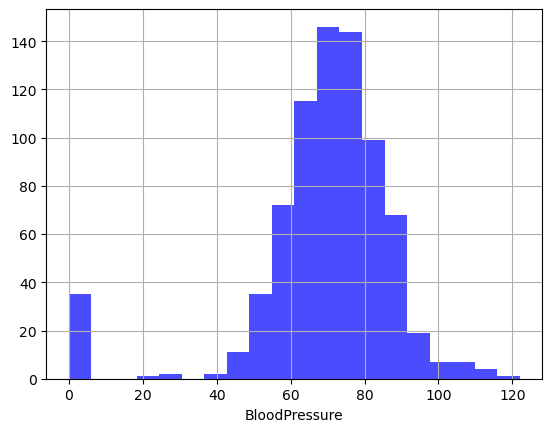

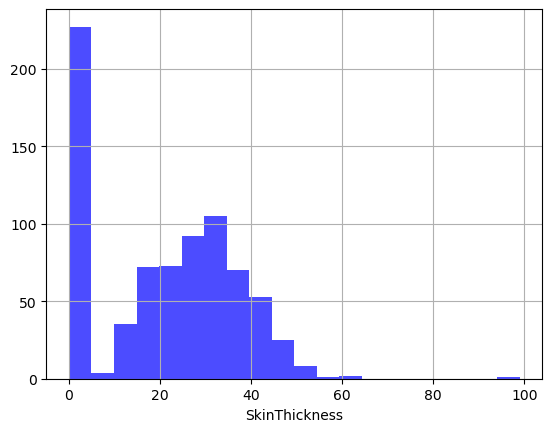

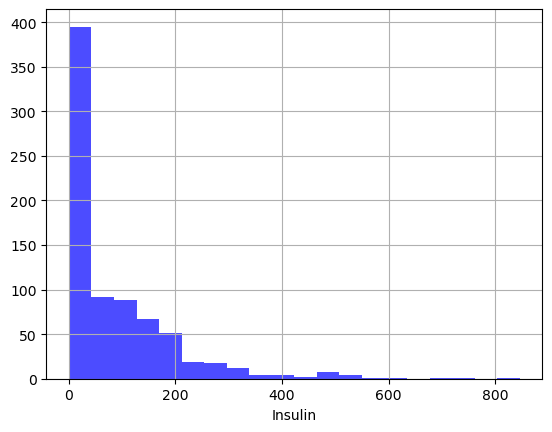

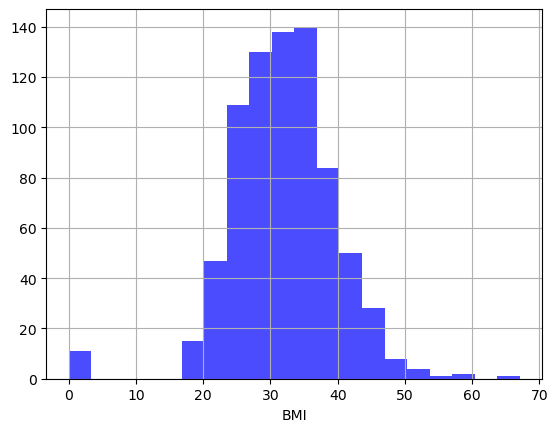

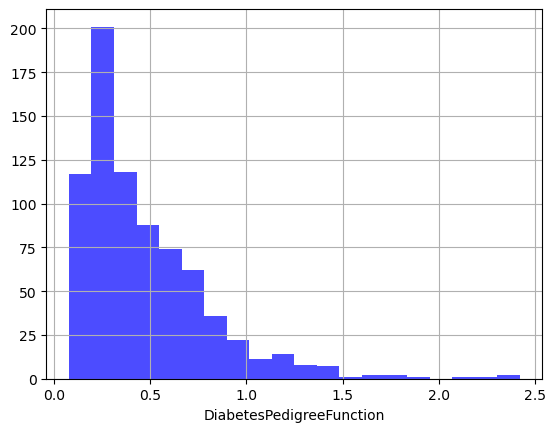

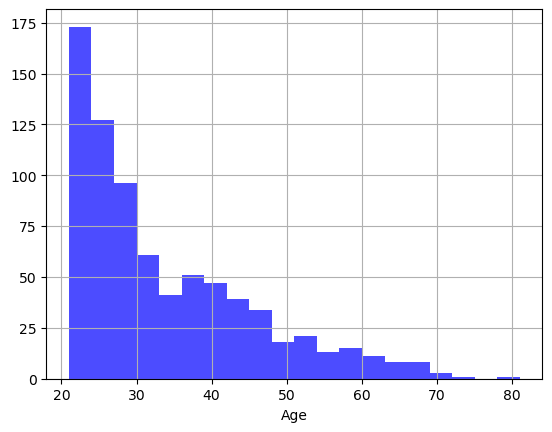

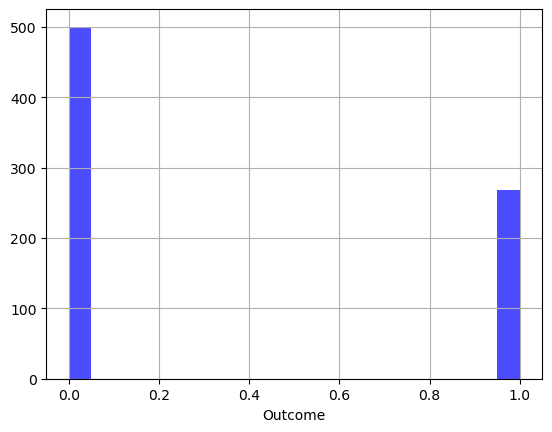

In [46]:
for col in df.columns:
	plot_numerical_col(df, col)

In [47]:
cols=[col for col in df.columns if "Outcome" not in col]

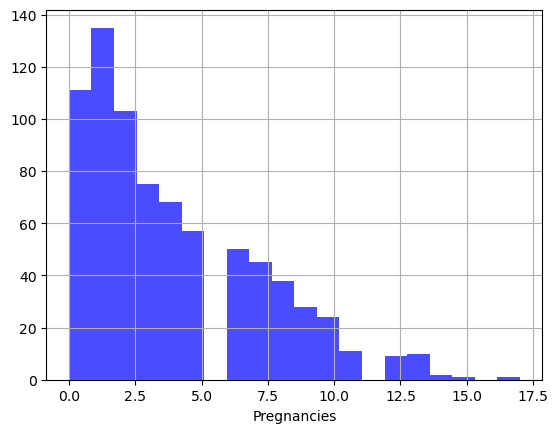

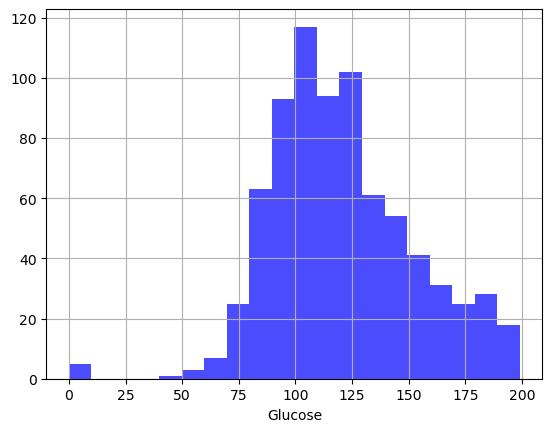

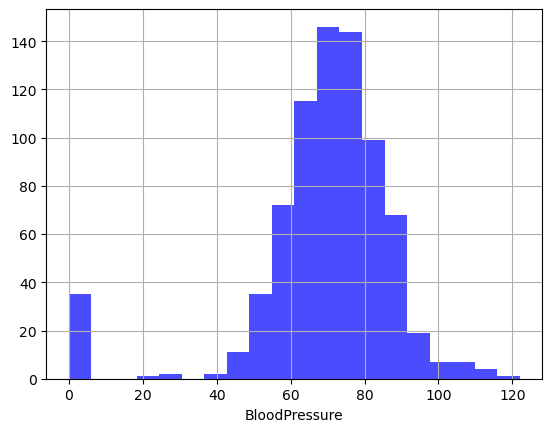

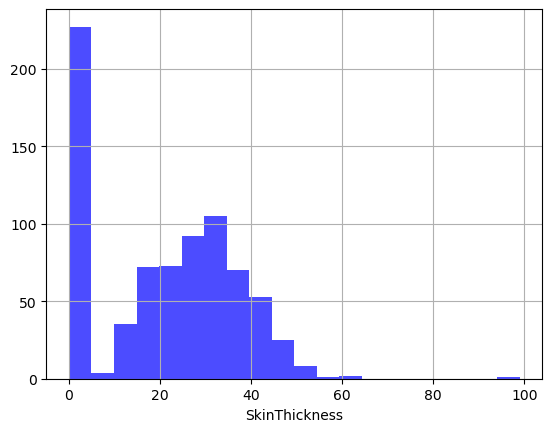

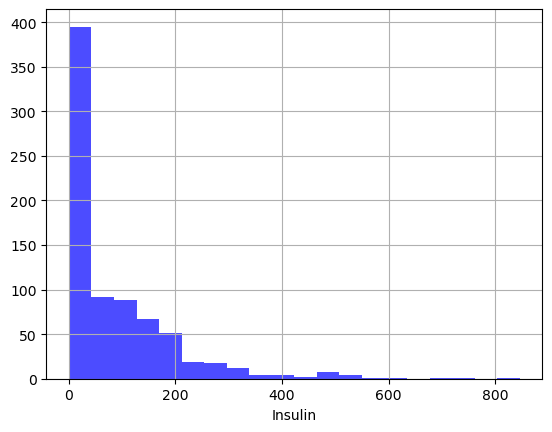

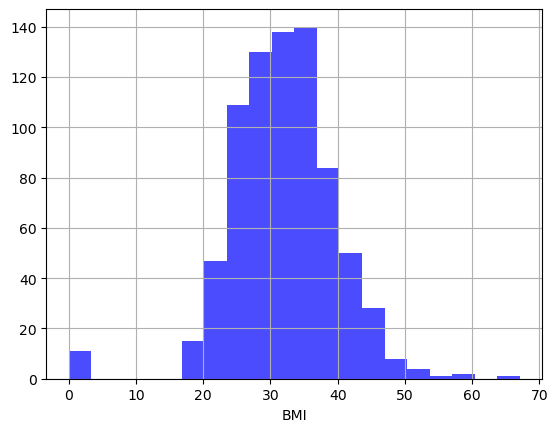

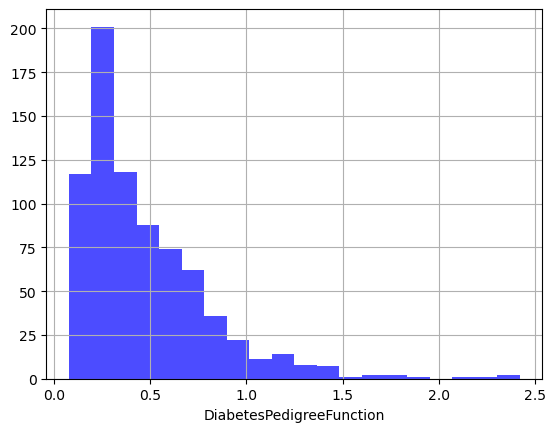

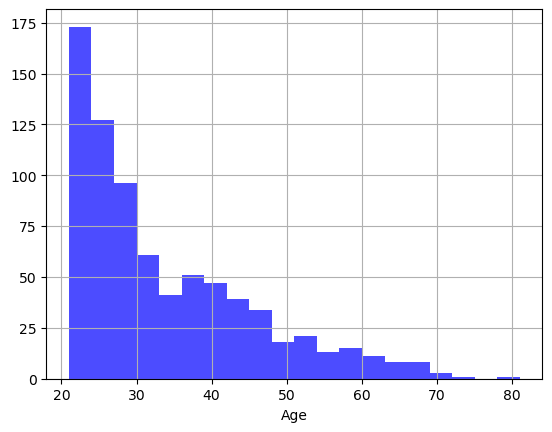

In [48]:
for col in cols:
	plot_numerical_col(df, col)

In [49]:
# Target & Features
df.groupby("Outcome").agg({"Pregnancies": "mean"})

,Pregnancies
Outcome,
0,3.298
1,4.866


In [50]:
def target_summary_with_sum(dataframe, target,numerical_col):
	print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n\n")

for col in cols:
	target_summary_with_sum(df, "Outcome", col)


         Pregnancies
Outcome             
0              3.298
1              4.866



         Glucose
Outcome         
0        109.980
1        141.257



         BloodPressure
Outcome               
0               68.184
1               70.825



         SkinThickness
Outcome               
0               19.664
1               22.164



         Insulin
Outcome         
0         68.792
1        100.336



           BMI
Outcome       
0       30.304
1       35.143



         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550



           Age
Outcome       
0       31.190
1       37.067





In [51]:
# Data Preprocessing

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [52]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [53]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [54]:
for col in df.columns:
	print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [55]:
replace_with_thresholds(df, "Insulin")

C:\Users\azizd\AppData\Local\Temp\ipykernel_30348\4171804645.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-439.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


In [56]:
for col in df.columns:
	print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [57]:
# Standartlaştırma

for col in cols:
	df[col]= RobustScaler().fit_transform(df[[col]]) # RobustScaler aykırı değerlerden etkilenmez

df.head() 

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1


In [58]:
# Model & Prediction
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

log_model = LogisticRegression().fit(X,y)

In [59]:
log_model.intercept_

array([-1.23367499])

In [60]:
log_model.coef_

array([[ 0.60026858,  1.41864488, -0.2317767 ,  0.02249032, -0.14660392,
         0.81662929,  0.35519151,  0.25514769]])

In [61]:
y_pred= log_model.predict(X)

In [62]:
y_pred[0:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0], dtype=int64)

In [ ]:
# Başarım değerlendirmesi
def plot_confusion_matrix(y, y_pred):
	acc= round(accuracy_score(y, y_pred), 2)
	cm = confusion_matrix(y, y_pred)
	sns.heatmap(cm, annot=True, fmt='.0f')# cmap='Blues'
	plt.xlabel('Predicted')
	plt.ylabel('True')
	plt.title('Accuracy Score: {}'.format(acc),size=10)
	plt.show()

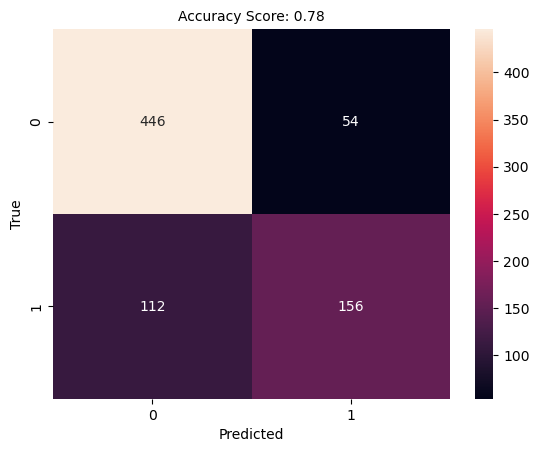

In [69]:
plot_confusion_matrix(y, y_pred)

In [70]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



In [72]:
# ROC AUC
y_prob= log_model.predict_proba(X)[:,1]
roc_auc_score(y, y_prob)

0.8394104477611941

In [98]:
# Model Validation: Holdout Method

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

log_model = LogisticRegression().fit(X_train, y_train)

y_pred = log_model.predict(X_test)

y_pred


array([0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
      dtype=int64)

In [99]:
y_prob = log_model.predict_proba(X_test)[:, 1]
y_prob

array([0.06809225, 0.67365438, 0.15585608, 0.04119581, 0.22646371,
       0.43004046, 0.12705719, 0.7924349 , 0.68292449, 0.78862421,
       0.69643437, 0.80302642, 0.13492147, 0.34593787, 0.14099574,
       0.13091007, 0.61431345, 0.15649586, 0.23167286, 0.25421389,
       0.78875139, 0.14553554, 0.04507752, 0.86725267, 0.3431623 ,
       0.20773803, 0.84258272, 0.01772846, 0.6549261 , 0.28877873,
       0.85038032, 0.32086082, 0.08155506, 0.10167123, 0.24489388,
       0.03776276, 0.76412312, 0.46229832, 0.05352819, 0.57506677,
       0.05119979, 0.05190382, 0.15259003, 0.9551443 , 0.03465737,
       0.31175661, 0.72176845, 0.334189  , 0.63193966, 0.45561962,
       0.28949252, 0.04523557, 0.42384282, 0.37397198, 0.50046549,
       0.71779056, 0.29590548, 0.19007888, 0.38127114, 0.09053889,
       0.27804216, 0.18536209, 0.17427249, 0.67757001, 0.20639182,
       0.06694268, 0.25669527, 0.2422082 , 0.3747364 , 0.22982086,
       0.7093583 , 0.13838351, 0.22125486, 0.07368505, 0.03168

In [100]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        97
           1       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



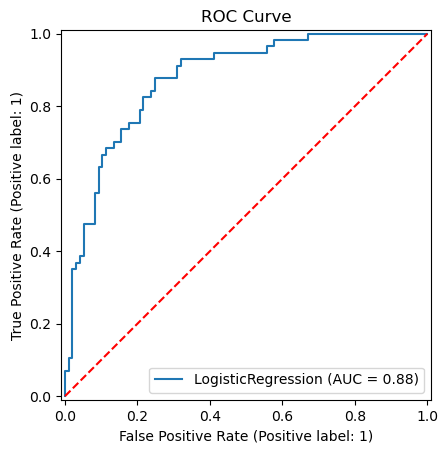

In [101]:
roc_curve=RocCurveDisplay.from_estimator(log_model, X_test, y_test)
plt.title("ROC Curve")
plt.plot([0,1],[0,1],'r--')
plt.show()

In [115]:
# Model Validation: K-Fold Cross Validation: 10 Katlı
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

y= df["Outcome"]
X= df.drop("Outcome", axis=1)

log_model = LogisticRegression().fit(X, y)


scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv_results = cross_validate(log_model, X, y, cv=10, scoring=scoring)

# Sonuçları görüntüleme
for metric in scoring:
    print(f"Mean {metric}: {cv_results[f'test_{metric}'].mean():.4f}")


Mean accuracy: 0.7722
Mean precision: 0.7315
Mean recall: 0.5597
Mean f1: 0.6314
Mean roc_auc: 0.8302


In [124]:
X.columns

random_user=X.sample(1, random_state=45)
log_model.predict(random_user)

array([1], dtype=int64)